In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.11.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [245]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_ply, load_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    TexturesUV
)

import chumpy
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
from plot_image_grid import image_grid

sys.path.append(os.path.abspath('../models/'))
from FLAME import FLAME

In [246]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [247]:
def get_vertex_normal(vertex, face):

    fv = torch.index_select(vertex, 0, face.reshape(-1)).reshape(*face.shape[:2], vertex.shape[-1])
    fd1 = fv[:, 1] - fv[:, 0]
    fd2 = fv[:, 2] - fv[:, 1]
    fn = torch.cross(fd1, fd2, dim=-1)
    
    fn_sums = torch.zeros_like(vertex)
    
    fn_sums = fn_sums.index_add(0, face[:,0], fn)
    fn_sums = fn_sums.index_add(0, face[:,1], fn)
    fn_sums = fn_sums.index_add(0, face[:,2], fn)
    
    fn_sums = F.normalize(fn_sums,dim=-1)
    
    return fn_sums

In [248]:
config = {
        # FLAME
        'flame_model_path': '../data/generic_model.pkl',  # acquire it from FLAME project page
        'flame_lmk_embedding_path': '../data/landmark_embedding.npy',
        'tex_space_path': '../data/FLAME_texture.npz',  # acquire it from FLAME project page
        'camera_params': 3,
        'shape_params': 100,
        'expression_params': 50,
        'pose_params': 6,
        'tex_params': 50,
        'use_face_contour': True,

        'cropped_size': 256,
        'batch_size': 1,
        'image_size': 224,
        'e_lr': 0.005,
        'e_wd': 0.0001,
        'savefolder': '../test_results/',
        # weights of losses and reg terms
        'w_pho': 8,
        'w_lmks': 1,
        'w_shape_reg': 1e-4,
        'w_expr_reg': 1e-4,
        'w_pose_reg': 0,
    }


def dict2obj(d):
    if isinstance(d, list):
        d = [dict2obj(x) for x in d]
    if not isinstance(d, dict):
        return d

    class C(object):
        pass

    o = C()
    for k in d:
        o.__dict__[k] = dict2obj(d[k])
    return o

config = dict2obj(config)

In [249]:
flame = FLAME(config).to(device)
vertices, landmarks2d, landmarks3d = flame(torch.zeros(1, config.shape_params).to(device), torch.zeros(1, config.expression_params).to(device), torch.zeros(1, config.pose_params).to(device))

creating the FLAME Decoder


In [271]:
verts, faces, aux = load_obj("../data/head_template_mesh.obj")
verts = verts[None, ...]
uvcoords = aux.verts_uvs[None, ...]  # (N, V, 2)
uvfaces = faces.textures_idx[None, ...]  # (N, F, 3)
faces = faces.verts_idx[None, ...]
# uv coordsw

#uvcoords = torch.cat([uvcoords, uvcoords[:, :, 0:1] * 0. + 1.], -1)  # [bz, ntv, 3]
#uvcoords = uvcoords * 2 - 1
#uvcoords[..., 1] = -uvcoords[..., 1]
#uvcoords[..., -1] = 0
        
verts[:,:,2] *= -1

grid = F.affine_grid(torch.eye(2,3).unsqueeze(0), (1, 2, 128, 128)).to(device)
grid = torch.cat([grid, torch.ones_like(grid)[..., :1]], dim=-1)
tex = TexturesUV(grid.to(device), uvfaces.to(device), uvcoords.to(device))

mesh = Meshes(
            verts=verts.to(device),
            faces=faces.to(device),
            textures=tex.to(device)
        )
mesh._compute_vertex_normals()



In [272]:

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));



In [277]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 64

# Get a batch of viewing angles. 
elev = torch.linspace(0, 0, num_views)
azim = torch.linspace(-120, -240, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.0, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

TypeError: __init__() missing 1 required positional argument: 'shader'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

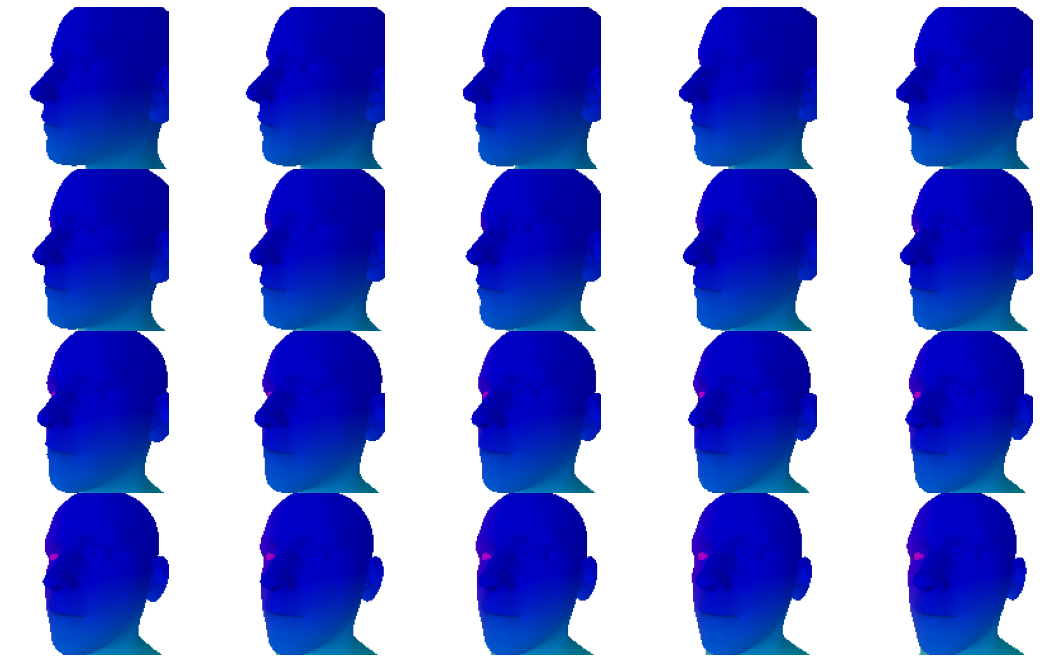

In [278]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


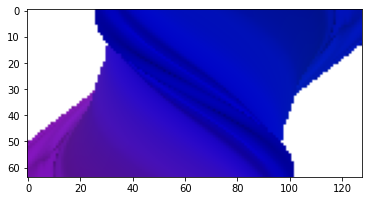

In [275]:
plt.imshow(target_images.cpu().numpy()[:, 75, :, :3])

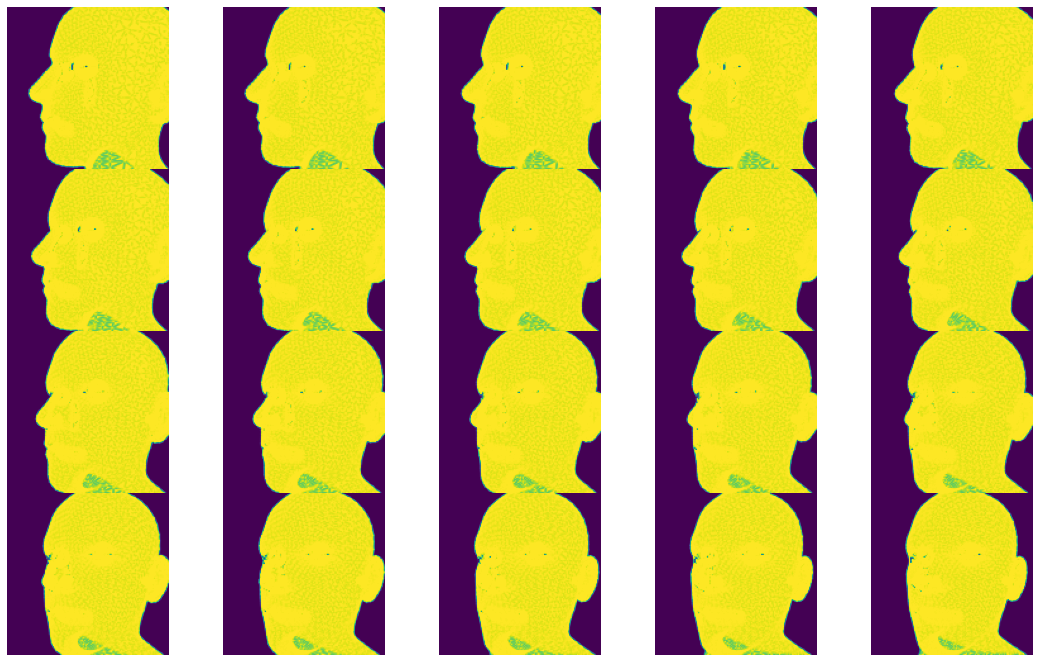

In [276]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

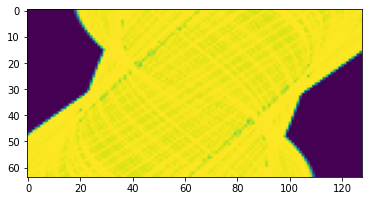

In [131]:
plt.imshow(silhouette_images.cpu().numpy()[:, 64, :, 3])

In [132]:
from PIL import Image
import numpy as np

imgs = []

for i in range(128):
    with Image.open(f'../video/{i}.png') as img:
        imgs.append(np.asarray(img))


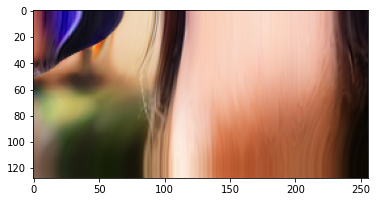

In [69]:
plt.imshow(np.array(imgs)[:, 32])

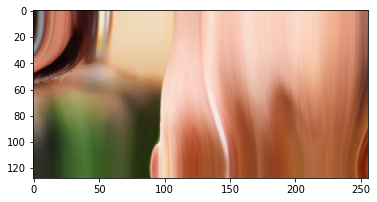

In [89]:
plt.imshow(np.array(imgs)[:, 100])

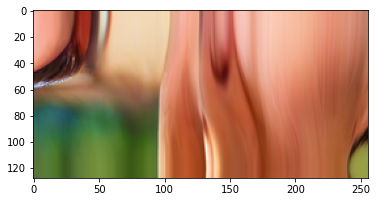

In [71]:
plt.imshow(np.array(imgs)[:, 128])

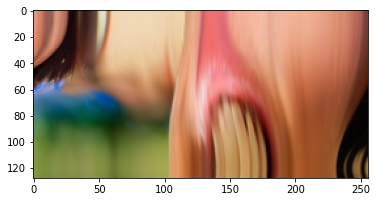

In [76]:
plt.imshow(np.array(imgs)[:, 160])

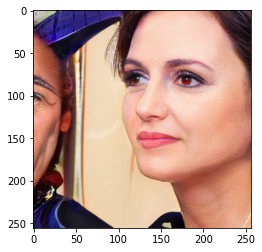

In [73]:
plt.imshow(np.array(imgs)[0])

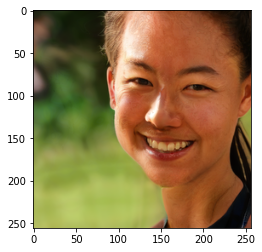

In [74]:
plt.imshow(np.array(imgs)[-1])